# Debugging and performances

In [1]:
# Hidden cell
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
print("xarray: %s, %s" % (xr.__version__, xr.__file__))

import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

import pyxpcm
print("pyxpcm: %s, %s" % (pyxpcm.__version__, pyxpcm.__file__))

xarray: 0.15.1, /Users/simon/anaconda3/envs/pyxpcm/lib/python3.6/site-packages/xarray/__init__.py
pyxpcm: 0.4.1, /Users/simon/anaconda3/envs/pyxpcm/lib/python3.6/site-packages/pyxpcm/__init__.py


**Import and set-up**

Import the library and toy data

In [2]:
import pyxpcm
from pyxpcm.models import pcm

# Load a dataset to work with:
ds = pyxpcm.tutorial.open_dataset('argo').load()

# Define vertical axis and features to use:
z = np.arange(0.,-1000.,-10.)
features_pcm = {'temperature': z, 'salinity': z}
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

## Debugging

Use option ``debug`` to print log messages 

In [3]:
# Instantiate a new PCM:
m = pcm(K=8, features=features_pcm, debug=True)

# Fit with log:
m.fit(ds, features=features_in_ds);

> Start preprocessing for action 'fit'

	> Preprocessing xarray dataset 'TEMP' as PCM feature 'temperature'
	 X RAVELED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))]
		Output axis is in the input axis, not need to interpolate, simple intersection
	 X INTERPOLATED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (100,))]
	 X SCALED with success) [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	 X REDUCED with success) [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	temperature pre-processed with success,  [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	Homogenisation for fit of temperature

	> Preprocessing xarray dataset 'PSAL' as PCM feature 'salinity'
	 X RAVELED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))]
		Output axis is in 

## Performance / Optimisation

Use ``timeit`` and ``timeit_verb`` to compute computation time of PCM operations

Times are accessible as a pandas Dataframe in ``timeit`` pyXpcm instance property.

The pyXpcm ``m.plot.timeit()`` plot method allows for a simple visualisation of times.

### Time readings during execution

In [4]:
# Create a PCM and execute methods:
m = pcm(K=8, features=features_pcm, timeit=True, timeit_verb=1)
m.fit(ds, features=features_in_ds);

  fit.1-preprocess.1-mask: 22 ms
  fit.1-preprocess.2-feature_temperature.1-ravel: 32 ms
  fit.1-preprocess.2-feature_temperature.2-interp: 1 ms
  fit.1-preprocess.2-feature_temperature.3-scale_fit: 10 ms
  fit.1-preprocess.2-feature_temperature.4-scale_transform: 5 ms
  fit.1-preprocess.2-feature_temperature.5-reduce_fit: 14 ms
  fit.1-preprocess.2-feature_temperature.6-reduce_transform: 3 ms
  fit.1-preprocess.2-feature_temperature.total: 68 ms
  fit.1-preprocess: 68 ms
  fit.1-preprocess.3-homogeniser: 1 ms
  fit.1-preprocess.2-feature_salinity.1-ravel: 28 ms
  fit.1-preprocess.2-feature_salinity.2-interp: 1 ms
  fit.1-preprocess.2-feature_salinity.3-scale_fit: 8 ms
  fit.1-preprocess.2-feature_salinity.4-scale_transform: 5 ms
  fit.1-preprocess.2-feature_salinity.5-reduce_fit: 12 ms
  fit.1-preprocess.2-feature_salinity.6-reduce_transform: 2 ms
  fit.1-preprocess.2-feature_salinity.total: 59 ms
  fit.1-preprocess: 59 ms
  fit.1-preprocess.3-homogeniser: 2 ms
  fit.1-preprocess.4-xa

### A posteriori Execution time analysis

In [5]:
# Create a PCM and execute methods:
m = pcm(K=8, features=features_pcm, timeit=True, timeit_verb=0)
m.fit(ds, features=features_in_ds);
m.predict(ds, features=features_in_ds);
m.fit_predict(ds, features=features_in_ds);

In [6]:
m.timeit

Method       Sub-method    Sub-sub-method         Sub-sub-sub-method
fit          1-preprocess  1-mask                 total                   22.065878
                           2-feature_temperature  1-ravel                 32.550812
                                                  2-interp                 0.667810
                                                  3-scale_fit              9.699821
                                                  4-scale_transform        4.242897
                                                  5-reduce_fit            11.743069
                                                  6-reduce_transform       2.529860
                                                  total                   61.564922
                           total                                         245.039225
                           3-homogeniser          total                    2.043009
                           2-feature_salinity     1-ravel                 20.107985
       

## Visualisation help

### Main steps by method

Sub-method,1-preprocess,fit,predict,score,xarray
Method,,,,,
fit,514.151812,2729.923248,NaN,13.323784,NaN
fit_predict,387.368441,1983.086109,11.361122,10.243893,9.186029
predict,423.865318,NaN,12.363911,12.063026,9.624243


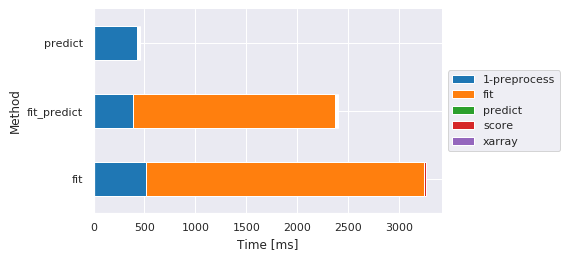

In [6]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-method', style='darkgrid') # Default group/split
df

### Preprocessing main steps by method

Sub-sub-method,1-mask,2-feature_salinity,2-feature_temperature,3-homogeniser,4-xarray
Method,,,,,
fit,24.156809,106.884956,121.825457,2.255440,1.127958
fit_predict,20.551920,77.168226,91.297626,2.600908,1.155853
predict,18.974066,93.832493,94.421148,2.175093,1.597881


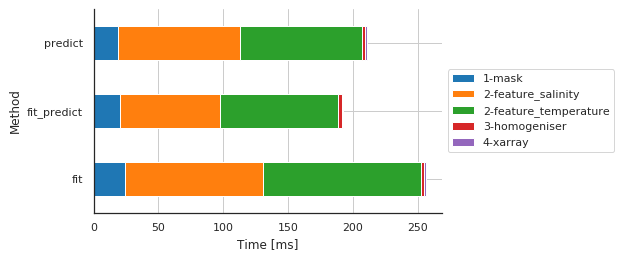

In [7]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-method')
df

### Preprocessing details by method

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Method,,,,,,
fit,56.342840,1.424551,18.775940,9.549141,22.963047,5.156755
fit_predict,64.214706,1.462936,0.001907,10.103941,0.004292,8.325100
predict,65.232277,2.182007,0.003099,16.474962,0.002861,10.085106


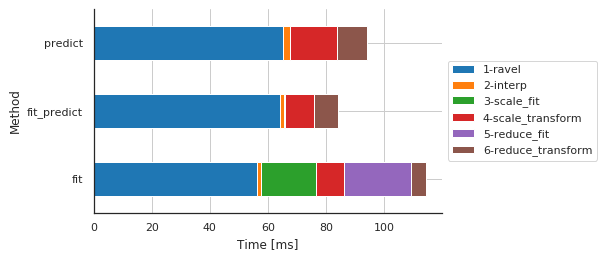

In [8]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-sub-method')
df

### Preprocessing details by features

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Sub-sub-method,,,,,,
2-feature_salinity,0.089095,0.002167,0.007607,0.019474,0.010604,0.009804
2-feature_temperature,0.096695,0.002902,0.011174,0.016654,0.012366,0.013763


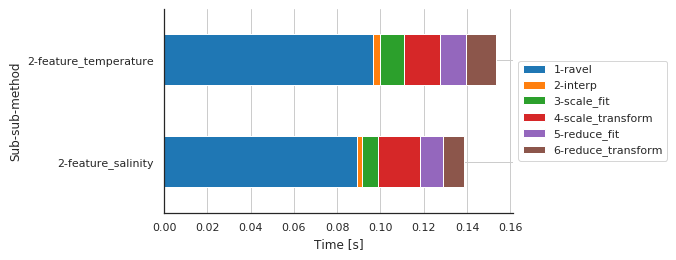

In [9]:
fig, ax, df = m.plot.timeit(split='Sub-sub-sub-method', group='Sub-sub-method', unit='s')
df